In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.layers import *
from keras.layers.merge import *
from keras.initializers import *
from keras.models import Model

In [0]:
from keras.optimizers import *
from keras.initializers import *
from keras.layers import *
from keras.layers.merge import *
from keras.models import *

residual_convolution_options = dict({
    'dropout_mode': 'spatial',
    'dropout_rate': 0.2,
    'filters': 64,
    'kernel_size': 1,
    'strides': 1,
    'padding': 'same',
    'activation': 'elu',
    'should_preactivate': True
})

def convolution_block(input_layer, options):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    convolution_block = convolution_input

    if(options['should_preactivate']):
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
    else:
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)

    convolution_output = convolution_block

    if(options['dropout_mode'] == 'spatial'):
        convolution_output = SpatialDropout1D(options['dropout_rate'])(convolution_output)
    if(options['dropout_mode']== 'vanilla'):
        convolution_output = Dropout(options['dropout_rate'])(convolution_output)

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def residual_add_block(input_layer, should_pool):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])
    
    residual_block_pool = convolution_input

    if(should_pool):
        residual_block_pool = MaxPooling1D(pool_size=2, strides=2, padding='same')(convolution_input)

    residual_block = add([
        residual_block_pool,
        convolution_block(residual_block_pool, residual_convolution_options)
    ])
    residual_block = add([
        residual_block,
        convolution_block(residual_block, residual_convolution_options)
    ])
    
    convolution_output = add([residual_block, residual_block_pool])

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def yoon_kim_feature_extractor(input_layer, filters):
    extractor_block_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    block_1_conv_1 = Conv1D(filters, 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_batchnorm1 = ELU()(block_1_batchnorm1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filters, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_batchnorm2 = ELU()(block_1_batchnorm2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filters, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_batchnorm3 = ELU()(block_1_batchnorm3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filters, 5, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_batchnorm4 = ELU()(block_1_batchnorm4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    extractor_block_output = Dropout(0.2)(features)
    
    return Model(
        inputs=[extractor_block_input], 
        outputs=[extractor_block_output]
    )(input_layer)

In [0]:
def classification_block(input_layer, dropout_rate = 0.2):
      
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)
    
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    classification_block_output = Dense(6, activation='sigmoid', kernel_initializer = 'glorot_normal')(model)
    
    return classification_block_output

In [12]:
max_words= 30000
max_words_length = 400
embedding_dimension = 300

input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)
averaged_embedding_layer_scaled = convolution_block(averaged_embedding_layer, residual_convolution_options)

model = residual_add_block(averaged_embedding_layer_scaled, should_pool = False)
model = residual_add_block(model, should_pool = True)
model = residual_add_block(model, should_pool = True)
model = residual_add_block(model, should_pool = True)

output_layer = yoon_kim_feature_extractor(model, residual_convolution_options['filters'])
output_layer = classification_block(output_layer)

model = Model(input_layer, output_layer)

model.compile(loss='binary_crossentropy', 
            optimizer='Adam',
            metrics=['accuracy'])          

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, epochs=64, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/64
 20576/102124 [=====>........................] - ETA: 3:20 - loss: 0.1309 - acc: 0.9570

 55872/102124 [===============>..............] - ETA: 1:44 - loss: 0.0921 - acc: 0.9694

 90560/102124 [=========================>....] - ETA: 25s - loss: 0.0815 - acc: 0.9725

102124/102124 [==============================] - 235s 2ms/step - loss: 0.0790 - acc: 0.9732 - val_loss: 0.0557 - val_acc: 0.9789
Epoch 2/64
  9216/102124 [=>............................] - ETA: 3:16 - loss: 0.0594 - acc: 0.9786

 44640/102124 [============>.................] - ETA: 2:02 - loss: 0.0586 - acc: 0.9791

 80480/102124 [======================>.......] - ETA: 46s - loss: 0.0582 - acc: 0.9791

102124/102124 [==============================] - 228s 2ms/step - loss: 0.0575 - acc: 0.9793 - val_loss: 0.0488 - val_acc: 0.9808
roc-auc: 0.981 - roc-auc_val: 0.9785                                                                                                    
Epoch 3/64
  3296/102124 [..............................] - ETA: 3:26 - loss: 0.0523 - acc: 0.9812

 39136/102124 [==========>...................] - ETA: 2:14 - loss: 0.0548 - acc: 0.9801

 74720/102124 [====================>.........] - ETA: 58s - loss: 0.0535 - acc: 0.9803

102124/102124 [==============================] - 228s 2ms/step - loss: 0.0533 - acc: 0.9803 - val_loss: 0.0448 - val_acc: 0.9831
Epoch 4/64
  2912/102124 [..............................] - ETA: 3:29 - loss: 0.0490 - acc: 0.9811

 38752/102124 [==========>...................] - ETA: 2:15 - loss: 0.0501 - acc: 0.9815

 74016/102124 [====================>.........] - ETA: 59s - loss: 0.0505 - acc: 0.9812

102124/102124 [==============================] - 227s 2ms/step - loss: 0.0505 - acc: 0.9811 - val_loss: 0.0443 - val_acc: 0.9830
roc-auc: 0.9862 - roc-auc_val: 0.9829                                                                                                    
Epoch 5/64
  1728/102124 [..............................] - ETA: 3:27 - loss: 0.0487 - acc: 0.9822

 35648/102124 [=========>....................] - ETA: 2:20 - loss: 0.0497 - acc: 0.9812

 71488/102124 [====================>.........] - ETA: 1:04 - loss: 0.0497 - acc: 0.9815

102124/102124 [==============================] - 226s 2ms/step - loss: 0.0490 - acc: 0.9816 - val_loss: 0.0457 - val_acc: 0.9822
Epoch 6/64
  1344/102124 [..............................] - ETA: 3:27 - loss: 0.0528 - acc: 0.9797

 36640/102124 [=========>....................] - ETA: 2:19 - loss: 0.0482 - acc: 0.9822

 72480/102124 [====================>.........] - ETA: 1:03 - loss: 0.0471 - acc: 0.9823

102124/102124 [==============================] - 228s 2ms/step - loss: 0.0476 - acc: 0.9820 - val_loss: 0.0414 - val_acc: 0.9839
roc-auc: 0.9892 - roc-auc_val: 0.9859                                                                                                    
Epoch 7/64
  1344/102124 [..............................] - ETA: 3:28 - loss: 0.0506 - acc: 0.9820

 37152/102124 [=========>....................] - ETA: 2:18 - loss: 0.0467 - acc: 0.9822

 73440/102124 [====================>.........] - ETA: 1:01 - loss: 0.0468 - acc: 0.9822

102124/102124 [==============================] - 228s 2ms/step - loss: 0.0466 - acc: 0.9823 - val_loss: 0.0417 - val_acc: 0.9837
Epoch 8/64
  2816/102124 [..............................] - ETA: 3:28 - loss: 0.0459 - acc: 0.9830

 40128/102124 [==========>...................] - ETA: 2:13 - loss: 0.0463 - acc: 0.9823

 75232/102124 [=====================>........] - ETA: 57s - loss: 0.0455 - acc: 0.9824

102124/102124 [==============================] - 229s 2ms/step - loss: 0.0456 - acc: 0.9825 - val_loss: 0.0415 - val_acc: 0.9838

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00024148408556357026.
roc-auc: 0.9904 - roc-auc_val: 0.9873                                                                                                    
Epoch 9/64
  1536/102124 [..............................] - ETA: 3:27 - loss: 0.0446 - acc: 0.9824

 37280/102124 [=========>....................] - ETA: 2:18 - loss: 0.0447 - acc: 0.9828

 72672/102124 [====================>.........] - ETA: 1:02 - loss: 0.0443 - acc: 0.9830

102124/102124 [==============================] - 228s 2ms/step - loss: 0.0447 - acc: 0.9829 - val_loss: 0.0414 - val_acc: 0.9838
Epoch 10/64
  2368/102124 [..............................] - ETA: 3:28 - loss: 0.0379 - acc: 0.9845

 38432/102124 [==========>...................] - ETA: 2:16 - loss: 0.0440 - acc: 0.9833

 74240/102124 [====================>.........] - ETA: 59s - loss: 0.0445 - acc: 0.9830

102124/102124 [==============================] - 228s 2ms/step - loss: 0.0445 - acc: 0.9830 - val_loss: 0.0406 - val_acc: 0.9843
roc-auc: 0.9912 - roc-auc_val: 0.9874                                                                                                    
Epoch 11/64
  1824/102124 [..............................] - ETA: 3:27 - loss: 0.0474 - acc: 0.9802

 38240/102124 [==========>...................] - ETA: 2:16 - loss: 0.0435 - acc: 0.9833

 73152/102124 [====================>.........] - ETA: 1:01 - loss: 0.0438 - acc: 0.9832

102124/102124 [==============================] - 228s 2ms/step - loss: 0.0439 - acc: 0.9832 - val_loss: 0.0419 - val_acc: 0.9833
Epoch 12/64
  2208/102124 [..............................] - ETA: 3:28 - loss: 0.0438 - acc: 0.9824

 37792/102124 [==========>...................] - ETA: 2:16 - loss: 0.0427 - acc: 0.9837

 73440/102124 [====================>.........] - ETA: 1:01 - loss: 0.0426 - acc: 0.9838

102124/102124 [==============================] - 227s 2ms/step - loss: 0.0433 - acc: 0.9834 - val_loss: 0.0414 - val_acc: 0.9836
roc-auc: 0.9914 - roc-auc_val: 0.9878                                                                                                    
Epoch 13/64
  1408/102124 [..............................] - ETA: 3:27 - loss: 0.0483 - acc: 0.9820

 37312/102124 [=========>....................] - ETA: 2:18 - loss: 0.0429 - acc: 0.9834

 73088/102124 [====================>.........] - ETA: 1:02 - loss: 0.0428 - acc: 0.9835

102124/102124 [==============================] - 228s 2ms/step - loss: 0.0430 - acc: 0.9834 - val_loss: 0.0420 - val_acc: 0.9836
Epoch 14/64
  2464/102124 [..............................] - ETA: 3:27 - loss: 0.0423 - acc: 0.9842

 37856/102124 [==========>...................] - ETA: 2:15 - loss: 0.0428 - acc: 0.9835

 73440/102124 [====================>.........] - ETA: 1:01 - loss: 0.0426 - acc: 0.9837

102124/102124 [==============================] - 227s 2ms/step - loss: 0.0427 - acc: 0.9835 - val_loss: 0.0410 - val_acc: 0.9838
roc-auc: 0.9918 - roc-auc_val: 0.9878                                                                                                    
Epoch 15/64
  1632/102124 [..............................] - ETA: 3:28 - loss: 0.0358 - acc: 0.9864

 35776/102124 [=========>....................] - ETA: 2:21 - loss: 0.0422 - acc: 0.9837

 70880/102124 [===================>..........] - ETA: 1:06 - loss: 0.0420 - acc: 0.9838

102124/102124 [==============================] - 227s 2ms/step - loss: 0.0422 - acc: 0.9837 - val_loss: 0.0416 - val_acc: 0.9837
Epoch 16/64
  1472/102124 [..............................] - ETA: 3:29 - loss: 0.0413 - acc: 0.9843

 36896/102124 [=========>....................] - ETA: 2:19 - loss: 0.0427 - acc: 0.9834

 74080/102124 [====================>.........] - ETA: 1:00 - loss: 0.0423 - acc: 0.9835

102124/102124 [==============================] - 229s 2ms/step - loss: 0.0425 - acc: 0.9834 - val_loss: 0.0411 - val_acc: 0.9840
roc-auc: 0.9921 - roc-auc_val: 0.9879                                                                                                    
Epoch 17/64
  1792/102124 [..............................] - ETA: 3:30 - loss: 0.0392 - acc: 0.9864

 38400/102124 [==========>...................] - ETA: 2:15 - loss: 0.0418 - acc: 0.9837

 73632/102124 [====================>.........] - ETA: 1:00 - loss: 0.0419 - acc: 0.9837

102124/102124 [==============================] - 227s 2ms/step - loss: 0.0419 - acc: 0.9837 - val_loss: 0.0401 - val_acc: 0.9844
Epoch 18/64
  2336/102124 [..............................] - ETA: 3:30 - loss: 0.0445 - acc: 0.9822

 35872/102124 [=========>....................] - ETA: 2:19 - loss: 0.0416 - acc: 0.9836

 70176/102124 [===================>..........] - ETA: 1:07 - loss: 0.0419 - acc: 0.9837

102124/102124 [==============================] - 226s 2ms/step - loss: 0.0419 - acc: 0.9837 - val_loss: 0.0408 - val_acc: 0.9842
roc-auc: 0.9923 - roc-auc_val: 0.9882                                                                                                    
Epoch 19/64
   672/102124 [..............................] - ETA: 3:28 - loss: 0.0466 - acc: 0.9824

 34944/102124 [=========>....................] - ETA: 2:21 - loss: 0.0420 - acc: 0.9838

 70240/102124 [===================>..........] - ETA: 1:07 - loss: 0.0421 - acc: 0.9838

102124/102124 [==============================] - 227s 2ms/step - loss: 0.0417 - acc: 0.9838 - val_loss: 0.0416 - val_acc: 0.9836

Epoch 00019: ReduceLROnPlateau reducing learning rate to 7.694652595091611e-05.
Epoch 20/64
  1024/102124 [..............................] - ETA: 3:29 - loss: 0.0368 - acc: 0.9829

 35680/102124 [=========>....................] - ETA: 2:20 - loss: 0.0405 - acc: 0.9841

 70208/102124 [===================>..........] - ETA: 1:07 - loss: 0.0407 - acc: 0.9841

102124/102124 [==============================] - 227s 2ms/step - loss: 0.0414 - acc: 0.9839 - val_loss: 0.0407 - val_acc: 0.9841
roc-auc: 0.9926 - roc-auc_val: 0.9883                                                                                                    
Epoch 21/64
  1056/102124 [..............................] - ETA: 3:28 - loss: 0.0366 - acc: 0.9856

 35488/102124 [=========>....................] - ETA: 2:21 - loss: 0.0410 - acc: 0.9839

 70944/102124 [===================>..........] - ETA: 1:06 - loss: 0.0409 - acc: 0.9841

102124/102124 [==============================] - 227s 2ms/step - loss: 0.0410 - acc: 0.9840 - val_loss: 0.0417 - val_acc: 0.9835
Epoch 22/64
  1216/102124 [..............................] - ETA: 3:32 - loss: 0.0437 - acc: 0.9830

 36352/102124 [=========>....................] - ETA: 2:19 - loss: 0.0400 - acc: 0.9843

 70560/102124 [===================>..........] - ETA: 1:06 - loss: 0.0405 - acc: 0.9842

102124/102124 [==============================] - 226s 2ms/step - loss: 0.0410 - acc: 0.9840 - val_loss: 0.0402 - val_acc: 0.9842
roc-auc: 0.9927 - roc-auc_val: 0.9882                                                                                                    
Epoch 23/64
   736/102124 [..............................] - ETA: 3:31 - loss: 0.0498 - acc: 0.9803

 38048/102124 [==========>...................] - ETA: 2:17 - loss: 0.0415 - acc: 0.9843

 73344/102124 [====================>.........] - ETA: 1:01 - loss: 0.0408 - acc: 0.9843

102124/102124 [==============================] - 229s 2ms/step - loss: 0.0410 - acc: 0.9841 - val_loss: 0.0408 - val_acc: 0.9836
Epoch 24/64
  2464/102124 [..............................]

 40928/102124 [===========>..................] - ETA: 2:10 - loss: 0.0399 - acc: 0.9846

 77984/102124 [=====================>........] - ETA: 51s - loss: 0.0409 - acc: 0.9842

102124/102124 [==============================] - 229s 2ms/step - loss: 0.0407 - acc: 0.9842 - val_loss: 0.0404 - val_acc: 0.9841
roc-auc: 0.9929 - roc-auc_val: 0.9883                                                                                                    
Epoch 25/64
  2848/102124 [..............................] - ETA: 3:29 - loss: 0.0412 - acc: 0.9844

 37440/102124 [=========>....................] - ETA: 2:17 - loss: 0.0394 - acc: 0.9846

 74752/102124 [====================>.........] - ETA: 58s - loss: 0.0404 - acc: 0.9843

102124/102124 [==============================] - 228s 2ms/step - loss: 0.0407 - acc: 0.9842 - val_loss: 0.0406 - val_acc: 0.9841
Epoch 26/64
  3136/102124 [..............................] - ETA: 3:30 - loss: 0.0444 - acc: 0.9834

 38336/102124 [==========>...................] - ETA: 2:17 - loss: 0.0412 - acc: 0.9839

 74624/102124 [====================>.........] - ETA: 59s - loss: 0.0404 - acc: 0.9841

102124/102124 [==============================] - 230s 2ms/step - loss: 0.0406 - acc: 0.9840 - val_loss: 0.0405 - val_acc: 0.9841
roc-auc: 0.993 - roc-auc_val: 0.9884                                                                                                    
Epoch 27/64
  1920/102124 [..............................] - ETA: 3:32 - loss: 0.0404 - acc: 0.9830

 36640/102124 [=========>....................] - ETA: 2:20 - loss: 0.0400 - acc: 0.9843

 71776/102124 [====================>.........] - ETA: 1:04 - loss: 0.0402 - acc: 0.9842

102124/102124 [==============================] - 228s 2ms/step - loss: 0.0403 - acc: 0.9843 - val_loss: 0.0402 - val_acc: 0.9842


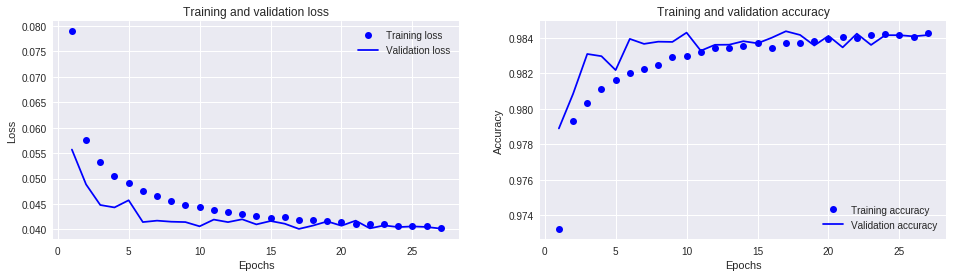

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 13s 410us/step
([0.0391009716538544, 0.984411704368433], 0.9899663989542948)
